# **Implementasi Self-Organizing Maps (SOM)**
## **Library**

In [5]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import bone, pcolor, colorbar
from sklearn.preprocessing import StandardScaler, LabelEncoder
from minisom import MiniSom
from collections import Counter
import pickle
import os
import time

import warnings
warnings.filterwarnings('ignore')

## **Data**

In [6]:
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 

# metadata 
print(online_retail.metadata) 

# variable information 
print(online_retail.variables)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [7]:
# load dataset into pandas dataframe
retail_data = online_retail.data.features.copy()
retail_data['InvoiceNo'] = online_retail.data.ids['InvoiceNo']
retail_data['StockCode'] = online_retail.data.ids['StockCode']
retail_data.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNo,StockCode
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,536365,85123A
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,536365,71053
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,536365,84406B
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,536365,84029G
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,536365,84029E


## **Preprocessing**
### **Handling Missing Values**

In [8]:
def handle_missing_values(df):
    """
    Handle missing values with detailed reporting
    """
    print("="*50)
    print("HANDLING MISSING VALUES")
    print("="*50)
    print("\nMissing values before cleaning:")
    print(df.isnull().sum())
    print(f"\nTotal rows: {len(df)}")
    
    initial_rows = len(df)
    
    # Remove rows with missing CustomerID (cannot aggregate without customer)
    df_clean = df.dropna(subset=['CustomerID'])
    after_customer = len(df_clean)
    
    # Remove rows with missing Description
    df_clean = df_clean.dropna(subset=['Description'])
    after_description = len(df_clean)
    
    print(f"\nMissing values after cleaning:")
    print(df_clean.isnull().sum())
    
    print(f"\nData Loss Summary:")
    print(f" - Removed due to missing CustomerID: {initial_rows - after_customer} rows")
    print(f" - Removed due to missing Description: {after_customer - after_description} rows")
    print(f" - Total removed: {initial_rows - after_description} rows ({(initial_rows - after_description)/initial_rows*100:.2f}%)")
    print(f" - Remaining: {after_description} rows")
    
    return df_clean

In [9]:
def clean_data_types(df):
    """
    Clean and convert data types with error handling
    """
    try:
        print("\n" + "="*50)
        print("CLEANING DATA TYPES")
        print("="*50)
        
        initial_rows = len(df)
        
        # Convert CustomerID to integer with error handling
        try:
            df['CustomerID'] = df['CustomerID'].astype(int)
        except ValueError as e:
            print(f"Warning: Could not convert some CustomerIDs to integer")
            df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce')
            df = df.dropna(subset=['CustomerID'])
            df['CustomerID'] = df['CustomerID'].astype(int)
        
        # Convert InvoiceDate to datetime with error handling
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
        
        # Check for invalid dates
        invalid_dates = df['InvoiceDate'].isnull().sum()
        if invalid_dates > 0:
            print(f"Warning: Found {invalid_dates} invalid dates, removing...")
            df = df.dropna(subset=['InvoiceDate'])
        
        df = df.copy()
        
        # Remove negative quantities and prices (returns/cancellations)
        negative_qty = (df['Quantity'] <= 0).sum()
        negative_price = (df['UnitPrice'] <= 0).sum()
        
        valid_mask = (df['Quantity'] > 0) & (df['UnitPrice'] > 0)
        df = df[valid_mask].copy()
        
        df = df[df['Quantity'] > 0]
        df = df[df['UnitPrice'] > 0]
        
        # Remove duplicates
        duplicates = df.duplicated().sum()
        df = df.drop_duplicates()
        
        print(f"\nCleaning Summary:")
        print(f" - Removed {negative_qty} rows with non-positive quantity")
        print(f" - Removed {negative_price} rows with non-positive price")
        print(f" - Removed {duplicates} duplicate rows")
        print(f" - Total removed: {initial_rows - len(df)} rows")
        print(f" - Remaining: {len(df)} rows")
        
        return df
        
    except Exception as e:
        print(f"Error in clean_data_types: {str(e)}")
        raise

### **Feature Engineering**

In [10]:
def create_customer_features(df):
    """
    Create RFM features with error handling
    """
    try:
        print("\n" + "="*50)
        print("CREATING CUSTOMER FEATURES")
        print("="*50)
        
        # Convert InvoiceDate to datetime if it's not already
        df = df.copy()
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
        
        # Check for invalid dates
        if df['InvoiceDate'].isnull().any():
            invalid_count = df['InvoiceDate'].isnull().sum()
            print(f"Warning: {invalid_count} invalid dates found, removing...")
            df = df.dropna(subset=['InvoiceDate'])
        
        # Reference date for recency calculation
        max_date = df['InvoiceDate'].max()
        snapshot_date = max_date + pd.Timedelta(days=1)
        
        print(f"   Reference date for recency: {snapshot_date.date()}")
        
        # Create TotalPrice if not exists
        if 'TotalPrice' not in df.columns:
            df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
        
        # Create RFM features
        rfm = df.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
            'InvoiceNo': 'nunique',  # Frequency
            'TotalPrice': 'sum'  # Monetary
        }).reset_index()
        
        rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
        
        # Additional features
        customer_features = df.groupby('CustomerID').agg({
            'Quantity': ['mean', 'std', 'sum'],
            'UnitPrice': ['mean', 'std'],
            'StockCode': 'nunique',  # Product variety
            'Country': 'first',  # Assuming customer's primary country
            'InvoiceDate': ['min', 'max']  # Customer tenure
        }).reset_index()
        
        # Flatten column names
        customer_features.columns = ['CustomerID', 'Avg_Quantity', 'Std_Quantity', 
                                    'Total_Quantity', 'Avg_UnitPrice', 'Std_UnitPrice',
                                    'Product_Variety', 'Country', 'First_Purchase', 
                                    'Last_Purchase']
        
        # Calculate customer tenure in days
        customer_features['Tenure_Days'] = (customer_features['Last_Purchase'] - 
                                            customer_features['First_Purchase']).dt.days
        
        # Merge RFM with additional features
        customer_features = customer_features.merge(rfm, on='CustomerID')
        
        # Fill NaN in Std_Quantity and Std_UnitPrice (customers with only 1 purchase)
        customer_features['Std_Quantity'].fillna(0, inplace=True)
        customer_features['Std_UnitPrice'].fillna(0, inplace=True)
        
        print(f"\nCreated features for {len(customer_features)} customers")
        print(f"   Features created: {list(customer_features.columns)}")
        
        return customer_features
        
    except Exception as e:
        print(f"Error in create_customer_features: {str(e)}")
        raise

### **Encoding**

In [11]:
def encode_categorical_features(df):
    """
    Encode categorical features with detailed reporting
    """
    print("\n" + "="*50)
    print("ENCODING CATEGORICAL FEATURES")
    print("="*50)
    
    # Label encode Country
    le_country = LabelEncoder()
    df['Country_Encoded'] = le_country.fit_transform(df['Country'])
    
    print(f"\nCountry encoding completed:")
    print(f" - Number of unique countries: {len(le_country.classes_)}")
    print(f" - Top 5 countries: {df['Country'].value_counts().head().to_dict()}")
    
    # Save country mapping for interpretation
    country_mapping = dict(zip(le_country.classes_, le_country.transform(le_country.classes_)))
    print(f"\nCountry encoding mapping (sample):")
    for country, code in list(country_mapping.items())[:5]:
        print(f"      {country}: {code}")
    
    return df, le_country

### **Handling Outliers**

In [12]:
def handle_outliers(df):
    """
    Handle outliers with detailed reporting
    """
    print("\n" + "="*50)
    print("HANDLING OUTLIERS")
    print("="*50)
    
    initial_rows = len(df)
    df = df.copy()  # Add explicit copy to avoid SettingWithCopyWarning
    
    # Identify numerical columns for outlier treatment
    numerical_cols = ['Recency', 'Frequency', 'Monetary', 'Avg_Quantity',
                        'Total_Quantity', 'Avg_UnitPrice', 'Product_Variety', 'Tenure_Days']
    
    # Apply log transformation to highly skewed features
    skewed_features = ['Frequency', 'Monetary', 'Total_Quantity', 'Product_Variety']
    
    print(f"\nApplying log transformation to: {skewed_features}")
    for feature in skewed_features:
        df[f'log_{feature}'] = np.log1p(df[feature])
        print(f"   - {feature}: skewness before = {df[feature].skew():.2f}, after = {df[f'log_{feature}'].skew():.2f}")
    
    # Remove extreme outliers using IQR method
    def remove_outliers_iqr(df, columns):
        df = df.copy()
        removed_per_feature = {}
        
        for col in columns:
            initial = len(df)
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            if IQR == 0:
                print(f"Warning: {col} has zero IQR, skipping outlier removal")
                removed_per_feature[col] = 0
                continue

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count outliers before removal
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
            removed_per_feature[col] = outliers
            
        return df, removed_per_feature
    
    # Use log-transformed features for outlier removal
    log_cols = [f'log_{feat}' for feat in skewed_features]
    other_cols = ['Recency', 'Avg_UnitPrice', 'Tenure_Days']
    
    print(f"\nRemoving outliers using IQR method (1.5 * IQR)...")
    df_clean, removed_counts = remove_outliers_iqr(df, log_cols + other_cols)
    
    print(f"\nOutliers removed per feature:")
    for feature, count in removed_counts.items():
        if count > 0:
            print(f" - {feature}: {count} rows ({count/initial_rows*100:.2f}%)")
    
    print(f"\nTotal customers after outlier removal: {len(df_clean)} (removed {initial_rows - len(df_clean)} rows, {(initial_rows - len(df_clean))/initial_rows*100:.2f}%)")
    
    return df_clean

### **Feature Selection**

In [13]:
def select_final_features(df):
    """
    Select final features for SOM analysis
    """
    # Choose relevant features for customer segmentation
    final_features = [
        'Recency',
        'log_Frequency', 
        'log_Monetary',
        'Avg_UnitPrice',
        'log_Product_Variety',
        'Tenure_Days',
        'Country_Encoded'
    ]
    
    # Create final dataset
    X_final = df[final_features].copy()
    
    # Handle any remaining missing values
    X_final = X_final.fillna(X_final.median())
    
    return X_final, final_features

### **Scaling**

In [14]:
def scale_features(X):
    """
    Scale features for SOM (crucial step!)
    """
    # Validasi: pastikan tidak ada infinity atau NaN
    if X.isnull().any().any():
        print("Warning: NaN detected in features, filling with median...")
        X = X.fillna(X.median())
    
    if np.isinf(X.values).any():
        print("Warning: Infinity detected in features, clipping...")
        X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert back to DataFrame for better handling
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    
    print("Feature scaling completed")
    print("Scaled features statistics:")
    print(X_scaled_df.describe())
    
    return X_scaled_df, scaler

### **Pipeline**

In [15]:
def complete_preprocessing_pipeline(df):
    """
    Complete preprocessing pipeline for Online Retail dataset
    """
    print("Starting preprocessing pipeline...")
    
    # Step 1: Handle missing values
    df_clean = handle_missing_values(df)
    
    # Step 2: Clean data types and remove invalid entries
    df_clean = clean_data_types(df_clean)
    
    # Step 3: Create customer features
    customer_df = create_customer_features(df_clean)
    
    # Step 4: Encode categorical variables
    customer_df, country_encoder = encode_categorical_features(customer_df)
    
    # Step 5: Handle outliers
    customer_df_clean = handle_outliers(customer_df)
    
    # Step 6: Select final features
    X_final, feature_names = select_final_features(customer_df_clean)
    
    # Step 7: Scale features
    X_scaled, scaler = scale_features(X_final)
    
    print("Preprocessing completed!")
    print(f"Final dataset: {X_scaled.shape[0]} customers, {X_scaled.shape[1]} features")
    
    return X_scaled, customer_df_clean, scaler, feature_names

# Run complete pipeline
X_ready, customer_data, feature_scaler, feature_names = complete_preprocessing_pipeline(retail_data)

Starting preprocessing pipeline...
HANDLING MISSING VALUES

Missing values before cleaning:
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
InvoiceNo           0
StockCode           0
dtype: int64

Total rows: 541909

Missing values after cleaning:
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
InvoiceNo      0
StockCode      0
dtype: int64

Data Loss Summary:
 - Removed due to missing CustomerID: 135080 rows
 - Removed due to missing Description: 0 rows
 - Total removed: 135080 rows (24.93%)
 - Remaining: 406829 rows

CLEANING DATA TYPES

Cleaning Summary:
 - Removed 8905 rows with non-positive quantity
 - Removed 40 rows with non-positive price
 - Removed 5192 duplicate rows
 - Total removed: 14137 rows
 - Remaining: 392692 rows

CREATING CUSTOMER FEATURES
   Reference date for recency: 2011-12-10

Created features for 4338 customers
   Features c

## **Modelling SOM**

### **Confoguration**

In [19]:
# SOM Configuration
SOM_CONFIG = {
    'map_size': (),
    'sigma': 1.5,
    'learning_rate': 0.5,
    'num_iterations': 10000,
    'random_seed': 42
}

### **Finding Optimal Map Size**

Size 5x5: QE=1.1741, TE=0.0652, Util=100.00%
Size 6x6: QE=1.1143, TE=0.0779, Util=100.00%
Size 7x7: QE=1.0192, TE=0.1155, Util=100.00%
Size 8x8: QE=0.9583, TE=0.1031, Util=100.00%
Size 9x9: QE=0.9202, TE=0.1585, Util=100.00%
Size 10x10: QE=0.8800, TE=0.1805, Util=100.00%
Size 11x11: QE=0.8504, TE=0.1513, Util=100.00%
Size 12x12: QE=0.8256, TE=0.1518, Util=98.61%
Size 13x13: QE=0.8030, TE=0.1874, Util=98.82%
Size 14x14: QE=0.7821, TE=0.1825, Util=97.96%
Size 15x15: QE=0.7500, TE=0.1861, Util=98.22%


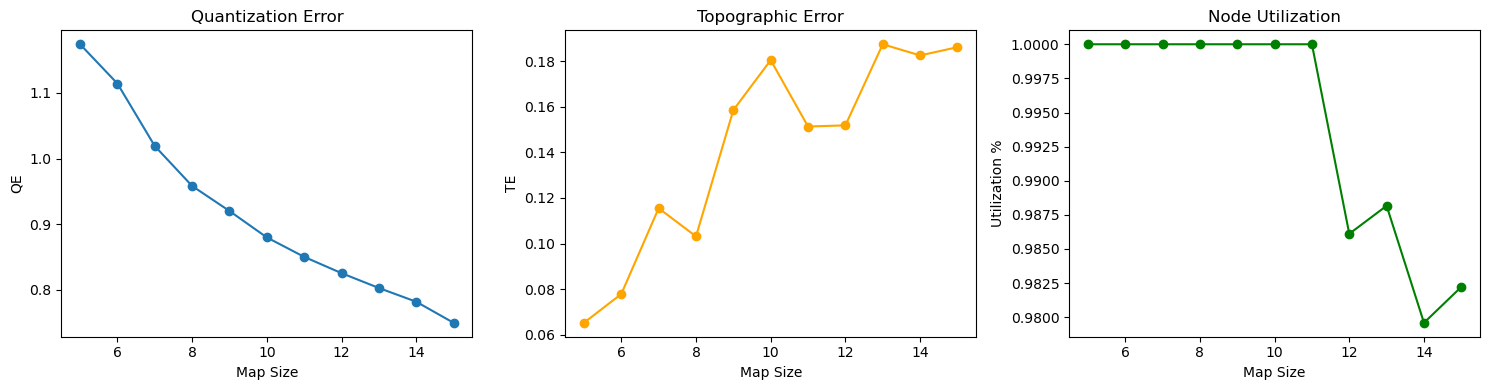

In [17]:
def find_optimal_map_size(X_data, size_range=range(5, 20, 2)):
    """
    Mencari ukuran map optimal berdasarkan quantization error
    """
    results = []
    
    for size in size_range:
        som = MiniSom(x=size, y=size, 
                    input_len=X_data.shape[1],
                    sigma=1.5, learning_rate=0.5,
                    random_seed=42)
        
        som.random_weights_init(X_data.values)
        som.train_random(data=X_data.values, num_iteration=5000, verbose=False)
        
        qe = som.quantization_error(X_data.values)
        te = som.topographic_error(X_data.values)
        
        # Node utilization
        winning_nodes = [som.winner(x) for x in X_data.values]
        utilization = len(set(winning_nodes)) / (size * size)
        
        results.append({
            'size': size,
            'qe': qe,
            'te': te,
            'utilization': utilization
        })
        
        print(f"Size {size}x{size}: QE={qe:.4f}, TE={te:.4f}, Util={utilization:.2%}")
    
    return pd.DataFrame(results)

# Jalankan pencarian
results = find_optimal_map_size(X_ready, size_range=range(5, 16, 1))

# Visualisasi
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(results['size'], results['qe'], marker='o')
axes[0].set_title('Quantization Error')
axes[0].set_xlabel('Map Size')
axes[0].set_ylabel('QE')

axes[1].plot(results['size'], results['te'], marker='o', color='orange')
axes[1].set_title('Topographic Error')
axes[1].set_xlabel('Map Size')
axes[1].set_ylabel('TE')

axes[2].plot(results['size'], results['utilization'], marker='o', color='green')
axes[2].set_title('Node Utilization')
axes[2].set_xlabel('Map Size')
axes[2].set_ylabel('Utilization %')

plt.tight_layout()
plt.show()


SELECTING OPTIMAL MAP SIZE

Ranking of Map Sizes:
--------------------------------------------------------------------------------
Rank   Size   QE         TE         Util         Score     
--------------------------------------------------------------------------------
1      12.0x12.0 0.8256     0.1518     98.61%       0.6216    
2      8.0x8.0 0.9583     0.1031     100.00%      0.6105    
3      15.0x15.0 0.7500     0.1861     98.22%       0.6103    
4      11.0x11.0 0.8504     0.1513     100.00%      0.5939    
5      14.0x14.0 0.7821     0.1825     97.96%       0.5899    
6      13.0x13.0 0.8030     0.1874     98.82%       0.5548    
7      6.0x6.0 1.1143     0.0779     100.00%      0.5254    
8      7.0x7.0 1.0192     0.1155     100.00%      0.5227    
9      9.0x9.0 0.9202     0.1585     100.00%      0.5104    
10     5.0x5.0 1.1741     0.0652     100.00%      0.5000    
11     10.0x10.0 0.8800     0.1805     100.00%      0.4945    

RECOMMENDED MAP SIZE: 12x12

Performance Me

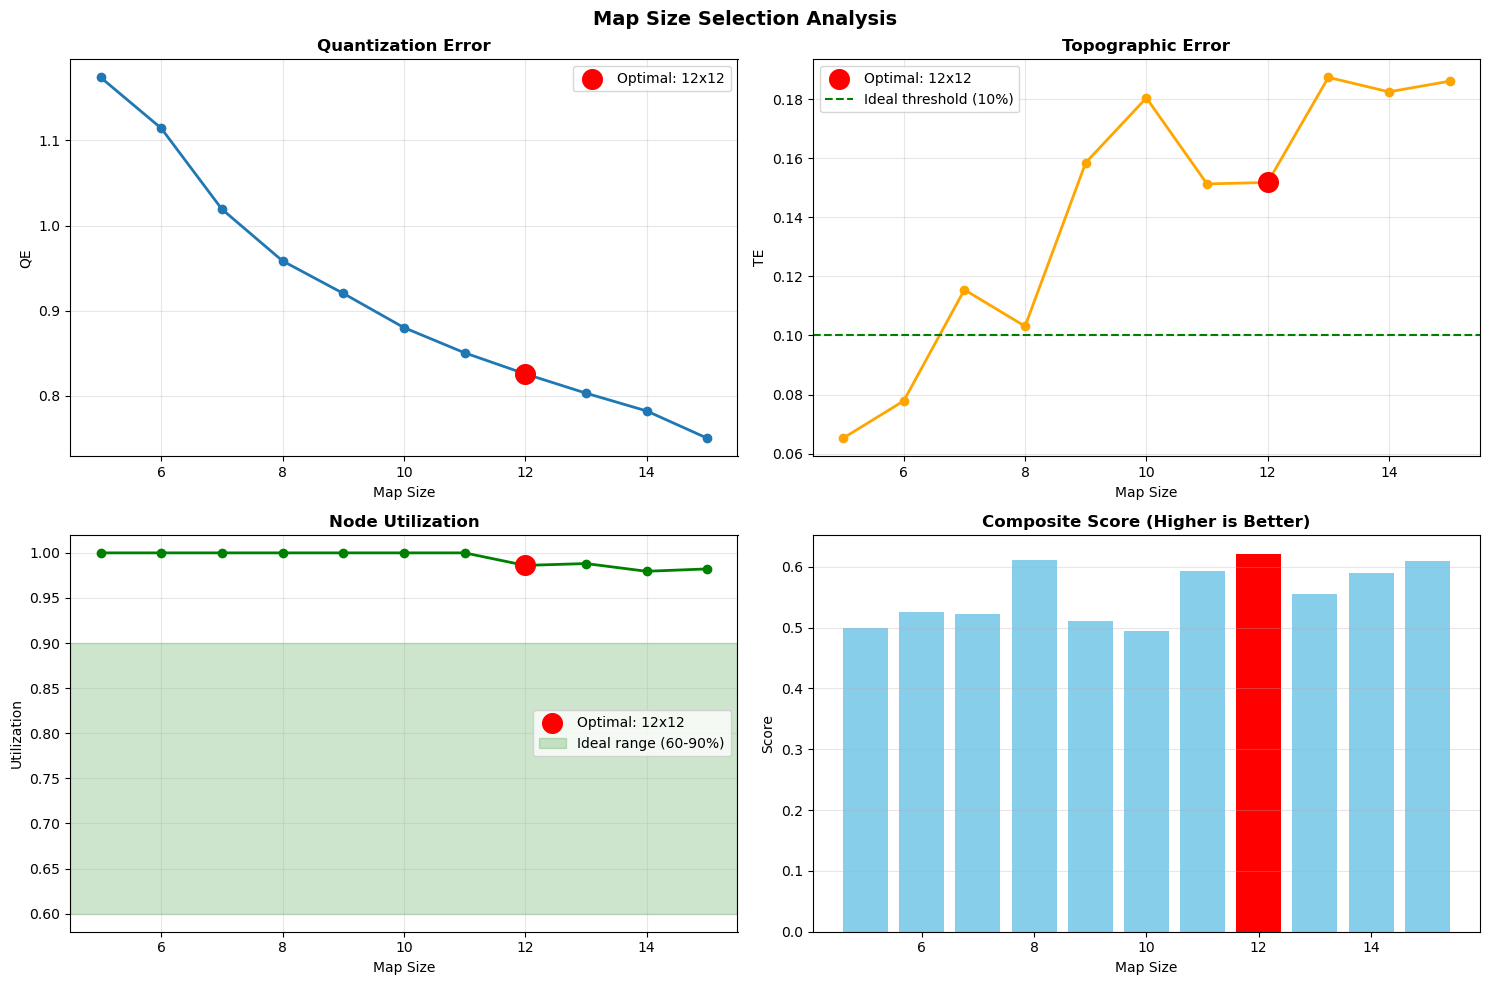


✓ SOM_CONFIG updated with optimal map size: 12x12


In [20]:
def select_optimal_map_size(results_df):
    """
    Memilih map size optimal berdasarkan kriteria:
    1. QE (Quantization Error) - semakin rendah semakin baik
    2. TE (Topographic Error) - idealnya < 10%
    3. Utilization - idealnya 60-90%
    """
    print("\n" + "="*60)
    print("SELECTING OPTIMAL MAP SIZE")
    print("="*60)
    
    # Normalize metrics untuk scoring (0-1 scale)
    # QE: lower is better, jadi kita inverse
    normalized_qe = 1 - (results_df['qe'] - results_df['qe'].min()) / (results_df['qe'].max() - results_df['qe'].min())
    
    # TE: lower is better, inverse
    normalized_te = 1 - (results_df['te'] - results_df['te'].min()) / (results_df['te'].max() - results_df['te'].min())
    
    # Utilization: optimal range 60-90%
    # Penalty untuk terlalu rendah atau tinggi
    optimal_util = 0.75  # target 75%
    util_penalty = np.abs(results_df['utilization'] - optimal_util) / optimal_util
    normalized_util = 1 - util_penalty
    normalized_util = normalized_util.clip(0, 1)
    
    # Composite score dengan bobot
    # QE = 40%, TE = 30%, Utilization = 30%
    results_df['score'] = (
        0.4 * normalized_qe + 
        0.3 * normalized_te + 
        0.3 * normalized_util
    )
    
    # Tampilkan hasil dengan ranking
    print("\nRanking of Map Sizes:")
    print("-" * 80)
    print(f"{'Rank':<6} {'Size':<6} {'QE':<10} {'TE':<10} {'Util':<12} {'Score':<10}")
    print("-" * 80)
    
    ranked = results_df.sort_values('score', ascending=False)
    for idx, (i, row) in enumerate(ranked.iterrows(), 1):
        print(f"{idx:<6} {row['size']}x{row['size']:<3} {row['qe']:<10.4f} {row['te']:<10.4f} {row['utilization']:<12.2%} {row['score']:<10.4f}")
    
    # Pilih yang terbaik
    best_idx = results_df['score'].idxmax()
    best_size = results_df.loc[best_idx, 'size']
    
    print("\n" + "="*60)
    print(f"RECOMMENDED MAP SIZE: {best_size}x{best_size}")
    print("="*60)
    
    print(f"\nPerformance Metrics:")
    print(f" - Quantization Error: {results_df.loc[best_idx, 'qe']:.4f}")
    print(f" - Topographic Error: {results_df.loc[best_idx, 'te']:.4f} ({results_df.loc[best_idx, 'te']*100:.2f}%)")
    print(f" - Node Utilization: {results_df.loc[best_idx, 'utilization']:.2%}")
    print(f" - Overall Score: {results_df.loc[best_idx, 'score']:.4f}")
    
    # Penjelasan
    print(f"\nWhy this size?")
    if results_df.loc[best_idx, 'te'] < 0.1:
        print(f" ✓ Low topographic error (<10%) - good topology preservation")
    if 0.6 <= results_df.loc[best_idx, 'utilization'] <= 0.9:
        print(f" ✓ Balanced utilization (60-90%) - neither too sparse nor too crowded")
    if results_df.loc[best_idx, 'qe'] <= results_df['qe'].quantile(0.3):
        print(f" ✓ Low quantization error - good data representation")
    
    return best_size, results_df

# Jalankan seleksi
optimal_size, results_with_scores = select_optimal_map_size(results)

# Visualisasi dengan highlight untuk map size terbaik
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: QE
axes[0, 0].plot(results['size'], results['qe'], marker='o', linewidth=2)
axes[0, 0].scatter(optimal_size, results[results['size']==optimal_size]['qe'].values[0], 
                    color='red', s=200, zorder=5, label=f'Optimal: {optimal_size}x{optimal_size}')
axes[0, 0].set_title('Quantization Error', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Map Size')
axes[0, 0].set_ylabel('QE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: TE
axes[0, 1].plot(results['size'], results['te'], marker='o', color='orange', linewidth=2)
axes[0, 1].scatter(optimal_size, results[results['size']==optimal_size]['te'].values[0], 
                    color='red', s=200, zorder=5, label=f'Optimal: {optimal_size}x{optimal_size}')
axes[0, 1].axhline(y=0.1, color='green', linestyle='--', label='Ideal threshold (10%)')
axes[0, 1].set_title('Topographic Error', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Map Size')
axes[0, 1].set_ylabel('TE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Utilization
axes[1, 0].plot(results['size'], results['utilization'], marker='o', color='green', linewidth=2)
axes[1, 0].scatter(optimal_size, results[results['size']==optimal_size]['utilization'].values[0], 
                    color='red', s=200, zorder=5, label=f'Optimal: {optimal_size}x{optimal_size}')
axes[1, 0].axhspan(0.6, 0.9, alpha=0.2, color='green', label='Ideal range (60-90%)')
axes[1, 0].set_title('Node Utilization', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Map Size')
axes[1, 0].set_ylabel('Utilization')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Composite Score
axes[1, 1].bar(results_with_scores['size'], results_with_scores['score'], 
                color=['red' if x == optimal_size else 'skyblue' for x in results_with_scores['size']])
axes[1, 1].set_title('Composite Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Map Size')
axes[1, 1].set_ylabel('Score')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Map Size Selection Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Update SOM_CONFIG dengan map size optimal
SOM_CONFIG['map_size'] = (optimal_size, optimal_size)
print(f"\n✓ SOM_CONFIG updated with optimal map size: {optimal_size}x{optimal_size}")

### **Training**

In [21]:
# Define SOM parameters
map_size_x = SOM_CONFIG['map_size'][0]
map_size_y = SOM_CONFIG['map_size'][1]
input_len = X_ready.shape[1]

# Initialize SOM
som = MiniSom(x=map_size_x, y=map_size_y, 
                input_len=input_len,
                sigma=1.5,
                learning_rate=0.5,
                neighborhood_function='gaussian',
                random_seed=42)

# Initialize weights
som.random_weights_init(X_ready.values)

# Train the SOM with progress tracking
print("Training SOM...")
print(f" - Map size: {map_size_x}x{map_size_y}")
print(f" - Input dimensions: {input_len}")
print(f" - Iterations: 10000")
print(f" - Initial learning rate: 0.5")
print(f" - Initial sigma: 1.5")

start_time = time.time()

# Train with quantization error tracking
som.train_random(data=X_ready.values, num_iteration=10000, verbose=False)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds!")

# Calculate initial quantization error
qe = som.quantization_error(X_ready.values)
print(f"Final Quantization Error: {qe:.4f}")

# Get winning nodes
winning_nodes = [som.winner(x) for x in X_ready.values]
print(f"Mapped {len(winning_nodes)} customers to SOM")

# Check node utilization
unique_nodes = len(set(winning_nodes))
total_nodes = map_size_x * map_size_y
print(f"Node utilization: {unique_nodes}/{total_nodes} ({unique_nodes/total_nodes*100:.1f}%)")

Training SOM...
 - Map size: 12x12
 - Input dimensions: 7
 - Iterations: 10000
 - Initial learning rate: 0.5
 - Initial sigma: 1.5
Training completed in 0.48 seconds!
Final Quantization Error: 0.8089
Mapped 3879 customers to SOM
Node utilization: 143/144 (99.3%)


## **Model Evaluation**


EVALUATING SOM QUALITY

SOM Quality Metrics:
 - Average Quantization Error: 0.8089 (±0.3576)
 - Topographic Error: 0.1686 (16.86%)

Interpretation:
 - Lower quantization error = better data representation
 - Lower topographic error = better topology preservation


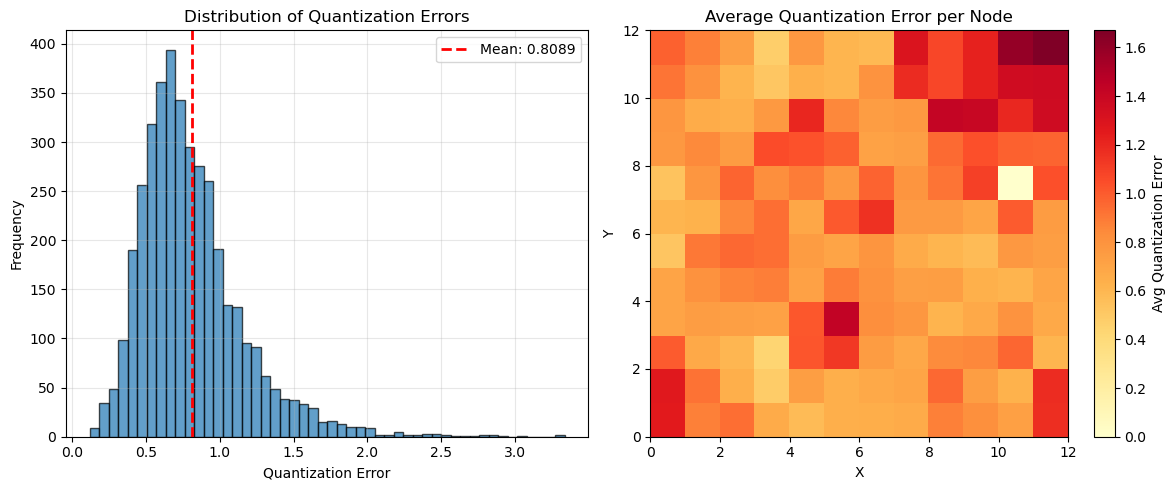

In [22]:
def evaluate_som_quality(som, X_data):
    """
    Calculate and visualize SOM quality metrics
    """
    print("\n" + "="*50)
    print("EVALUATING SOM QUALITY")
    print("="*50)
    
    # Quantization Error
    quantization_errors = [np.linalg.norm(x - som.get_weights()[som.winner(x)]) 
                            for x in X_data.values]
    avg_qe = np.mean(quantization_errors)
    std_qe = np.std(quantization_errors)
    
    # Topographic Error
    topographic_error = som.topographic_error(X_data.values)
    
    print(f"\nSOM Quality Metrics:")
    print(f" - Average Quantization Error: {avg_qe:.4f} (±{std_qe:.4f})")
    print(f" - Topographic Error: {topographic_error:.4f} ({topographic_error*100:.2f}%)")
    
    print(f"\nInterpretation:")
    print(f" - Lower quantization error = better data representation")
    print(f" - Lower topographic error = better topology preservation")
    
    # Visualize quantization errors
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(quantization_errors, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(avg_qe, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_qe:.4f}')
    plt.xlabel('Quantization Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Quantization Errors')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    qe_map = np.zeros((som._weights.shape[0], som._weights.shape[1]))
    qe_counts = {}
    
    for x, qe in zip(X_data.values, quantization_errors):
        winner = som.winner(x)
        if winner not in qe_counts:
            qe_counts[winner] = []
        qe_counts[winner].append(qe)
    
    for position, qe_list in qe_counts.items():
        qe_map[position] = np.mean(qe_list)
    
    plt.pcolor(qe_map.T, cmap='YlOrRd')
    plt.colorbar(label='Avg Quantization Error')
    plt.title('Average Quantization Error per Node')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.tight_layout()
    plt.show()
    
    return avg_qe, topographic_error, quantization_errors

# Call evaluation
avg_qe, topo_error, qe_list = evaluate_som_quality(som, X_ready)

## **Result Visualization**


VISUALIZING SOM RESULTS


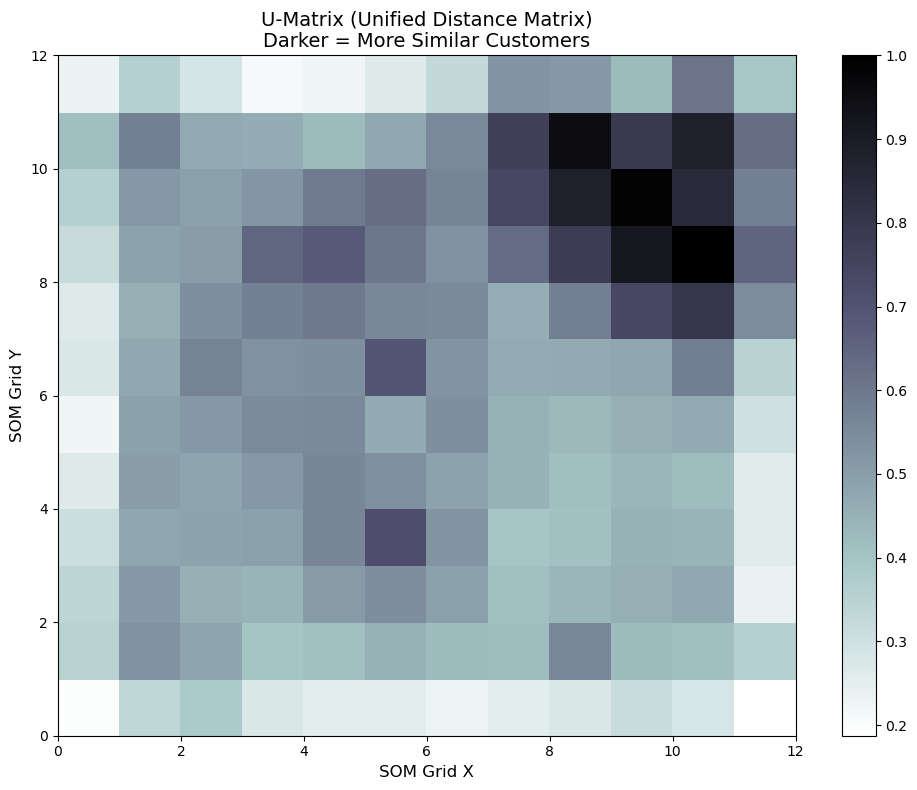

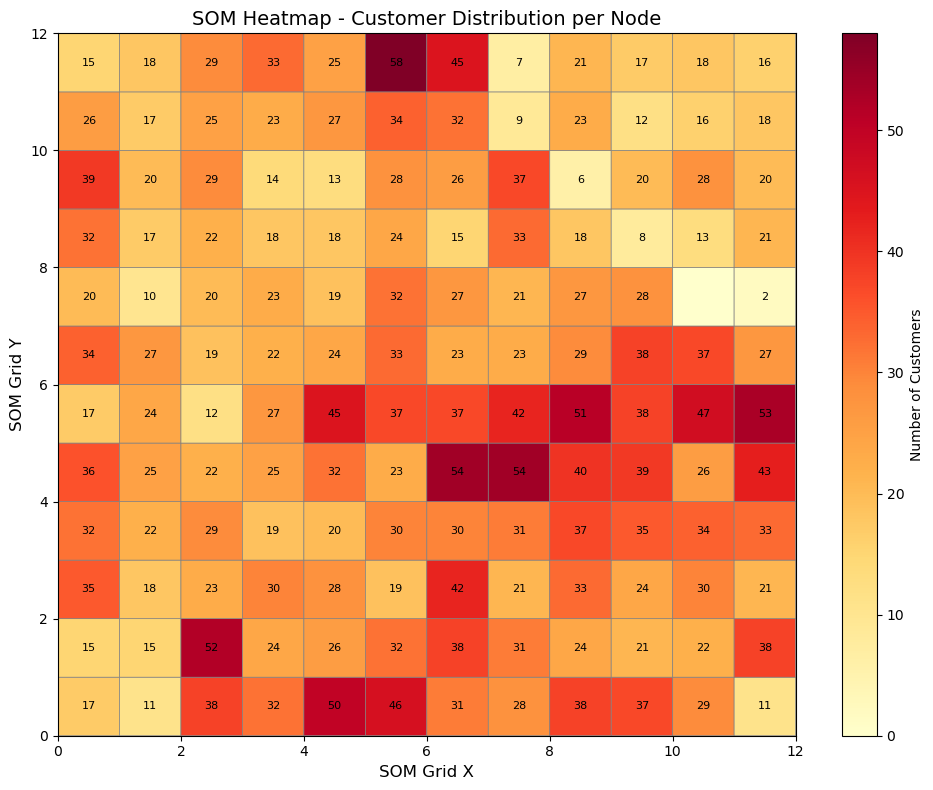

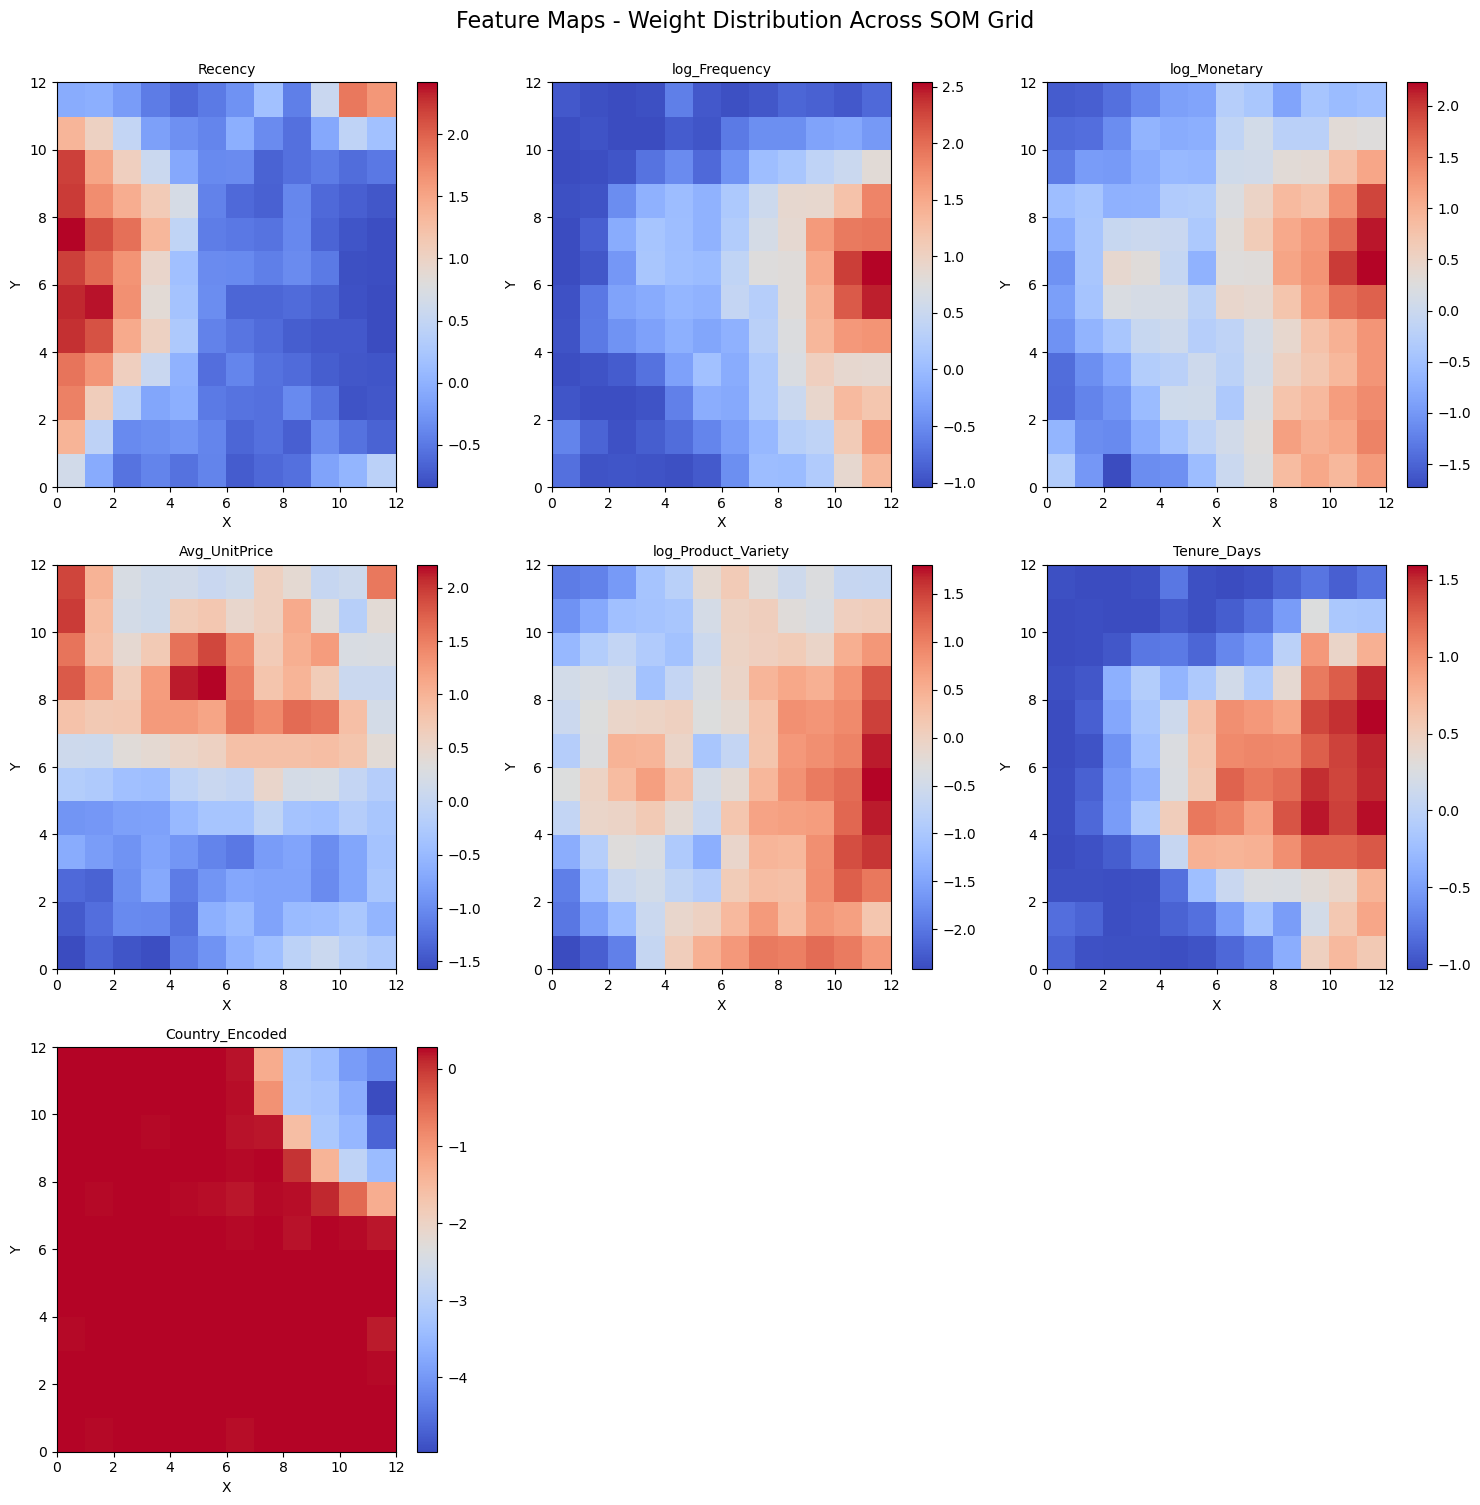

In [23]:
def visualize_som_results(som, X_ready, customer_data):
    """
    Comprehensive SOM visualization
    """
    print("\n" + "="*50)
    print("VISUALIZING SOM RESULTS")
    print("="*50)
    
    # U-Matrix (Distance Map)
    plt.figure(figsize=(10, 8))
    bone()
    distance_map = som.distance_map()
    pcolor(distance_map.T, cmap='bone_r')
    colorbar()
    plt.title('U-Matrix (Unified Distance Matrix)\nDarker = More Similar Customers', fontsize=14)
    plt.xlabel('SOM Grid X', fontsize=12)
    plt.ylabel('SOM Grid Y', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Heatmap (Customer Distribution)
    plt.figure(figsize=(10, 8))
    frequencies = Counter([som.winner(x) for x in X_ready.values])
    heat_map = np.zeros((som._weights.shape[0], som._weights.shape[1]))
    
    for position, freq in frequencies.items():
        heat_map[position] = freq

    plt.pcolor(heat_map.T, cmap='YlOrRd', edgecolors='gray', linewidths=0.5)
    plt.colorbar(label='Number of Customers')
    plt.title('SOM Heatmap - Customer Distribution per Node', fontsize=14)
    plt.xlabel('SOM Grid X', fontsize=12)
    plt.ylabel('SOM Grid Y', fontsize=12)
    
    # Add text annotations for nodes with customers
    for i in range(heat_map.shape[0]):
        for j in range(heat_map.shape[1]):
            if heat_map[i, j] > 0:
                plt.text(i+0.5, j+0.5, int(heat_map[i, j]), 
                        ha='center', va='center', fontsize=8, color='black')
    
    plt.tight_layout()
    plt.show()
    
    # Feature Maps
    feature_names = X_ready.columns
    n_features = len(feature_names)
    n_cols = 3
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for idx, feature in enumerate(feature_names):
        feature_map = np.zeros((som._weights.shape[0], som._weights.shape[1]))
        
        for i in range(som._weights.shape[0]):
            for j in range(som._weights.shape[1]):
                feature_map[i, j] = som._weights[i, j, idx]
        
        im = axes[idx].pcolor(feature_map.T, cmap='coolwarm')
        axes[idx].set_title(f'{feature}', fontsize=10)
        axes[idx].set_xlabel('X')
        axes[idx].set_ylabel('Y')
        plt.colorbar(im, ax=axes[idx])
    
    # Hide empty subplots
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Feature Maps - Weight Distribution Across SOM Grid', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()
    
# Visualize SOM results
visualize_som_results(som, X_ready, customer_data)

## **Cluster Analysis**


ANALYZING CUSTOMER CLUSTERS

Total unique clusters: 143
 Clusters with >10 customers: 137

Top 10 largest clusters:
5_11    58
6_4     54
7_4     54
11_5    53
2_1     52
8_5     51
4_0     50
10_5    47
5_0     46
4_5     45
Name: cluster_id, dtype: int64

Profile of Top 5 Clusters:

Cluster 5_11 (n=58 customers):
 - Recency: 31.6 days (avg)
 - Frequency: 1.2 purchases (avg)
 - Monetary: $253.55 (avg)
 - Avg Order Value: $2.95
 - Product Variety: 33.9 unique products
 - Tenure: 5 days

Cluster 6_4 (n=54 customers):
 - Recency: 35.7 days (avg)
 - Frequency: 2.4 purchases (avg)
 - Monetary: $526.34 (avg)
 - Avg Order Value: $2.59
 - Product Variety: 61.6 unique products
 - Tenure: 286 days

Cluster 7_4 (n=54 customers):
 - Recency: 29.1 days (avg)
 - Frequency: 3.7 purchases (avg)
 - Monetary: $895.43 (avg)
 - Avg Order Value: $2.88
 - Product Variety: 93.9 unique products
 - Tenure: 226 days

Cluster 11_5 (n=53 customers):
 - Recency: 10.3 days (avg)
 - Frequency: 19.1 purchases (avg)

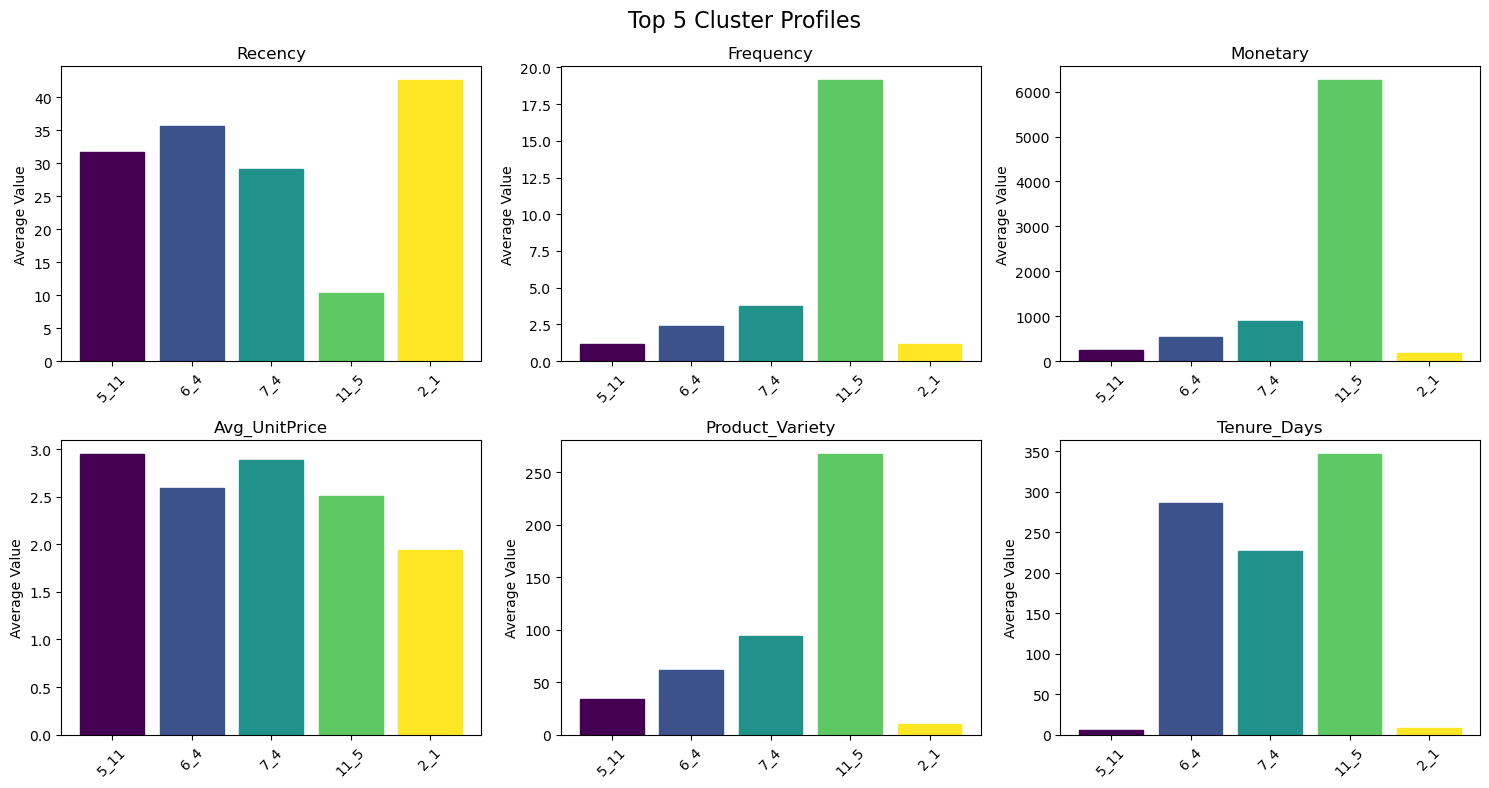

In [24]:
def analyze_clusters(som, X_data, customer_data, feature_names, n_clusters=5):
    """
    Analyze and profile customer segments from SOM
    """
    print("\n" + "="*50)
    print("ANALYZING CUSTOMER CLUSTERS")
    print("="*50)
        
    # Reset indices to ensure alignment
    customer_data = customer_data.reset_index(drop=True).copy()
    X_data = X_data.reset_index(drop=True)
    
    # Assign cluster labels based on winning nodes
    customer_data = customer_data.copy()
    customer_data['cluster_x'] = [som.winner(x)[0] for x in X_data.values]
    customer_data['cluster_y'] = [som.winner(x)[1] for x in X_data.values]
    customer_data['cluster_id'] = customer_data['cluster_x'].astype(str) + '_' + customer_data['cluster_y'].astype(str)
    
    # Count customers per cluster
    cluster_sizes = customer_data['cluster_id'].value_counts()
    print(f"\nTotal unique clusters: {len(cluster_sizes)}")
    print(f" Clusters with >10 customers: {(cluster_sizes > 10).sum()}")
    print(f"\nTop 10 largest clusters:")
    print(cluster_sizes.head(10))
    
    # Profile clusters with original features (not log-transformed)
    profile_features = ['Recency', 'Frequency', 'Monetary', 'Avg_UnitPrice', 
                        'Product_Variety', 'Tenure_Days']
    
    cluster_profiles = customer_data.groupby('cluster_id')[profile_features].agg(['mean', 'median', 'count'])
    
    # Get top 5 clusters by size
    top_clusters = cluster_sizes.head(5).index
    
    print(f"\nProfile of Top 5 Clusters:")
    print("="*80)
    for cluster_id in top_clusters:
        profile = cluster_profiles.loc[cluster_id]
        size = cluster_sizes[cluster_id]
        
        print(f"\nCluster {cluster_id} (n={size} customers):")
        print(f" - Recency: {profile[('Recency', 'mean')]:.1f} days (avg)")
        print(f" - Frequency: {profile[('Frequency', 'mean')]:.1f} purchases (avg)")
        print(f" - Monetary: ${profile[('Monetary', 'mean')]:.2f} (avg)")
        print(f" - Avg Order Value: ${profile[('Avg_UnitPrice', 'mean')]:.2f}")
        print(f" - Product Variety: {profile[('Product_Variety', 'mean')]:.1f} unique products")
        print(f" - Tenure: {profile[('Tenure_Days', 'mean')]:.0f} days")
    
    # Visualize cluster profiles
    plt.figure(figsize=(15, 8))
    
    for i, feature in enumerate(profile_features, 1):
        plt.subplot(2, 3, i)
        top_cluster_data = cluster_profiles.loc[top_clusters, (feature, 'mean')]
        
        bars = plt.bar(range(len(top_cluster_data)), top_cluster_data.values)
        plt.xticks(range(len(top_cluster_data)), top_cluster_data.index, rotation=45)
        plt.title(feature)
        plt.ylabel('Average Value')
        
        # Color bars by value
        colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
        for bar, color in zip(bars, colors):
            bar.set_color(color)
    
    plt.suptitle('Top 5 Cluster Profiles', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return customer_data, cluster_profiles

# Call analysis
customer_data_clustered, cluster_profiles = analyze_clusters(som, X_ready, customer_data, feature_names)

In [25]:
# Add new cell after cluster analysis
def interpret_clusters(customer_data_clustered, cluster_profiles, top_n=5):
    """
    Provide business interpretation of clusters
    """
    print("\n" + "="*50)
    print("CLUSTER INTERPRETATION")
    print("="*50)
    
    cluster_sizes = customer_data_clustered['cluster_id'].value_counts()
    top_clusters = cluster_sizes.head(top_n).index
    
    # Define cluster interpretation logic
    for cluster_id in top_clusters:
        profile = cluster_profiles.loc[cluster_id]
        size = cluster_sizes[cluster_id]
        
        recency = profile[('Recency', 'mean')]
        frequency = profile[('Frequency', 'mean')]
        monetary = profile[('Monetary', 'mean')]
        
        print(f"\n{'='*60}")
        print(f"Cluster {cluster_id} - {size} customers ({size/len(customer_data_clustered)*100:.1f}%)")
        print(f"{'='*60}")
        
        # RFM-based interpretation
        if recency < 50 and frequency > 5 and monetary > 1000:
            segment = "VIP Customers (Champions)"
            action = "Reward loyalty, exclusive offers, premium service"
        elif recency < 50 and frequency > 3:
            segment = "Loyal Customers"
            action = "Upsell, cross-sell, maintain engagement"
        elif recency > 180 and frequency < 2:
            segment = "At-Risk/Hibernating"
            action = "Re-engagement campaigns, win-back offers"
        elif recency < 90 and frequency == 1:
            segment = "New Customers"
            action = "Onboarding, first purchase incentives"
        elif monetary > 2000:
            segment = "Big Spenders"
            action = "Premium products, volume discounts"
        else:
            segment = "Regular Customers"
            action = "Standard marketing, retention programs"
        
        print(f"Segment: {segment}")
        print(f"Recommended Action: {action}")
        print(f"\nKey Metrics:")
        print(f" - Recency: {recency:.0f} days")
        print(f" - Frequency: {frequency:.1f} purchases")
        print(f" - Monetary: ${monetary:.2f}")
        print(f" - Avg Order: ${profile[('Avg_UnitPrice', 'mean')]:.2f}")
        print(f" - Product Variety: {profile[('Product_Variety', 'mean')]:.0f}")
        print(f" - Customer Age: {profile[('Tenure_Days', 'mean')]:.0f} days")

# Call interpretation
interpret_clusters(customer_data_clustered, cluster_profiles)


CLUSTER INTERPRETATION

Cluster 5_11 - 58 customers (1.5%)
Segment: Regular Customers
Recommended Action: Standard marketing, retention programs

Key Metrics:
 - Recency: 32 days
 - Frequency: 1.2 purchases
 - Monetary: $253.55
 - Avg Order: $2.95
 - Product Variety: 34
 - Customer Age: 5 days

Cluster 6_4 - 54 customers (1.4%)
Segment: Regular Customers
Recommended Action: Standard marketing, retention programs

Key Metrics:
 - Recency: 36 days
 - Frequency: 2.4 purchases
 - Monetary: $526.34
 - Avg Order: $2.59
 - Product Variety: 62
 - Customer Age: 286 days

Cluster 7_4 - 54 customers (1.4%)
Segment: Loyal Customers
Recommended Action: Upsell, cross-sell, maintain engagement

Key Metrics:
 - Recency: 29 days
 - Frequency: 3.7 purchases
 - Monetary: $895.43
 - Avg Order: $2.88
 - Product Variety: 94
 - Customer Age: 226 days

Cluster 11_5 - 53 customers (1.4%)
Segment: VIP Customers (Champions)
Recommended Action: Reward loyalty, exclusive offers, premium service

Key Metrics:
 - R

## **Model Performance**

In [26]:
# Add new cell before saving:
def summarize_som_performance(som, X_ready, customer_data_clustered, avg_qe, topo_error):
    """
    Create comprehensive model performance summary
    """
    print("\n" + "="*70)
    print(" " * 20 + "SOM MODEL SUMMARY")
    print("="*70)
    
    print(f"\nDataset Information:")
    print(f" - Total customers: {len(X_ready)}")
    print(f" - Features: {X_ready.shape[1]}")
    print(f" - Feature names: {list(X_ready.columns)}")
    
    print(f"\nSOM Architecture:")
    print(f" - Grid size: {som._weights.shape[0]}x{som._weights.shape[1]} = {som._weights.shape[0]*som._weights.shape[1]} nodes")
    print(f" - Neighborhood function: gaussian")
    print(f" - Initial learning rate: 0.5")
    print(f" - Initial sigma: 1.5")
    print(f" - Training iterations: 10,000")
    
    print(f"\nModel Quality:")
    print(f" - Quantization Error: {avg_qe:.4f}")
    print(f" - Topographic Error: {topo_error:.4f} ({topo_error*100:.2f}%)")
    
    # Node utilization
    winning_nodes = [som.winner(x) for x in X_ready.values]
    unique_nodes = len(set(winning_nodes))
    total_nodes = som._weights.shape[0] * som._weights.shape[1]
    utilization = unique_nodes / total_nodes * 100

    print(f"\nCluster Statistics:")
    print(f" - Active nodes: {unique_nodes}/{total_nodes} ({utilization:.1f}%)")
    print(f" - Unique clusters: {customer_data_clustered['cluster_id'].nunique()}")
    print(f" - Avg customers per cluster: {len(customer_data_clustered)/unique_nodes:.1f}")
    
    cluster_sizes = customer_data_clustered['cluster_id'].value_counts()
    print(f" - Largest cluster: {cluster_sizes.iloc[0]} customers")
    print(f" - Smallest cluster: {cluster_sizes.iloc[-1]} customers")
    
    print("\n" + "="*70)

# Call summary
summarize_som_performance(som, X_ready, customer_data_clustered, avg_qe, topo_error)


                    SOM MODEL SUMMARY

Dataset Information:
 - Total customers: 3879
 - Features: 7
 - Feature names: ['Recency', 'log_Frequency', 'log_Monetary', 'Avg_UnitPrice', 'log_Product_Variety', 'Tenure_Days', 'Country_Encoded']

SOM Architecture:
 - Grid size: 12x12 = 144 nodes
 - Neighborhood function: gaussian
 - Initial learning rate: 0.5
 - Initial sigma: 1.5
 - Training iterations: 10,000

Model Quality:
 - Quantization Error: 0.8089
 - Topographic Error: 0.1686 (16.86%)

Cluster Statistics:
 - Active nodes: 143/144 (99.3%)
 - Unique clusters: 143
 - Avg customers per cluster: 27.1
 - Largest cluster: 58 customers
 - Smallest cluster: 2 customers



## **Model Saving**

In [19]:
def save_som_model(som, scaler, feature_names, customer_data, save_dir='models'):
    """
    Save trained SOM model and related objects
    """
    print("\n" + "="*50)
    print("SAVING MODEL")
    print("="*50)
    
    # Create directory if not exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Save SOM model
    model_data = {
        'som': som,
        'scaler': scaler,
        'feature_names': feature_names,
        'customer_data': customer_data,
        'config': SOM_CONFIG
    }
    
    model_path = os.path.join(save_dir, 'som_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"Model saved to: {model_path}")
    print(f"   Model size: {os.path.getsize(model_path) / 1024:.2f} KB")
    
    return model_path

# Save model
model_path = save_som_model(som, feature_scaler, feature_names, customer_data_clustered)


SAVING MODEL
Model saved to: models\som_model.pkl
   Model size: 646.89 KB
